### Задача

Правда ли бикас дает преимущество? Или лучше разгонять без всяких там бикасов

`$ ipcluster start`

In [1]:
from ipyparallel import Client
cl = Client()
lbv = cl.load_balanced_view()
print(f'Запущено {len(lbv)} ядер')

Запущено 12 ядер


In [2]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [3]:
cl[:]['wd'] = wd

In [4]:
%%px --local
print(wd)

D:\pyKas
[stdout:0] D:\pyKas
[stdout:1] D:\pyKas
[stdout:2] D:\pyKas
[stdout:3] D:\pyKas
[stdout:4] D:\pyKas
[stdout:5] D:\pyKas
[stdout:6] D:\pyKas
[stdout:7] D:\pyKas
[stdout:8] D:\pyKas
[stdout:9] D:\pyKas
[stdout:10] D:\pyKas
[stdout:11] D:\pyKas


In [5]:
%%px
import os
import sys
sys.path.append(wd+"\\src\\")

In [6]:
%%px --local
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
from powderlayer import PowderBD, PowderOvLayer, Powder
from gaslayer import GasEOS, GasLayer
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [7]:
%%px --local
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [8]:
%%px --local
import json
from functional import seq

#### Простая цилиндрическая пушка

q_max = 0.26999999999999996


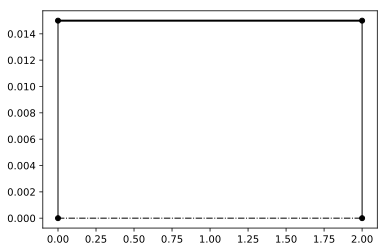

[stdout:0] q_max = 0.26999999999999996
[stdout:1] q_max = 0.26999999999999996
[stdout:2] q_max = 0.26999999999999996
[stdout:3] q_max = 0.26999999999999996
[stdout:4] q_max = 0.26999999999999996
[stdout:5] q_max = 0.26999999999999996
[stdout:6] q_max = 0.26999999999999996
[stdout:7] q_max = 0.26999999999999996
[stdout:8] q_max = 0.26999999999999996
[stdout:9] q_max = 0.26999999999999996
[stdout:10] q_max = 0.26999999999999996
[stdout:11] q_max = 0.26999999999999996


[output:0]

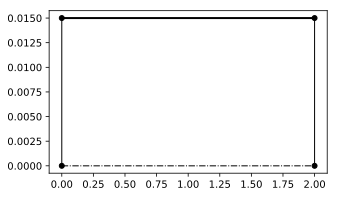

[output:1]

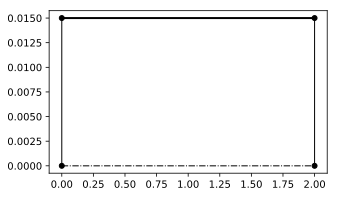

[output:2]

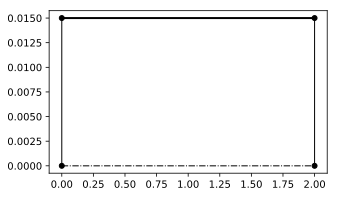

[output:3]

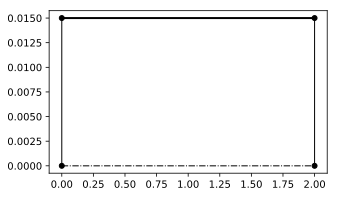

[output:4]

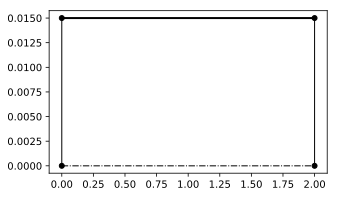

[output:5]

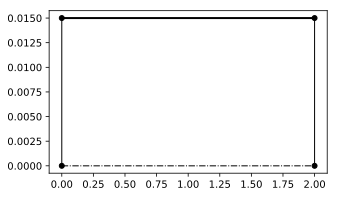

[output:6]

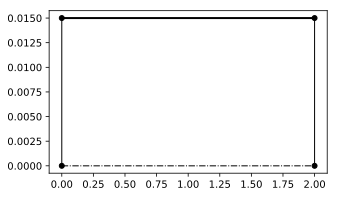

[output:7]

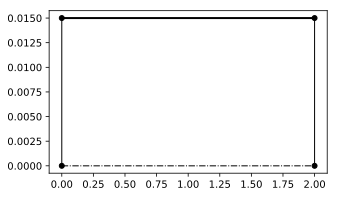

[output:8]

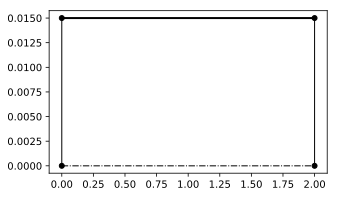

[output:9]

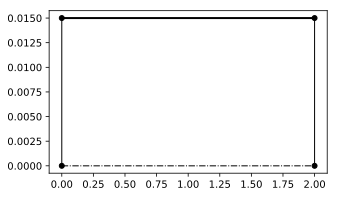

[output:10]

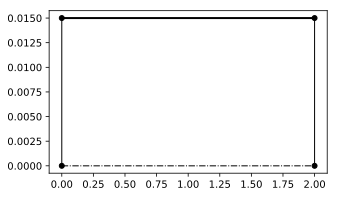

[output:11]

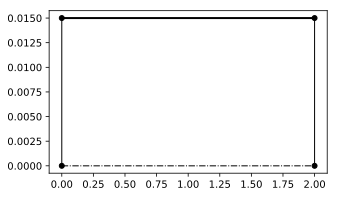

In [12]:
%%px --local
d = 0.03
C_q_max = 10
q_max = C_q_max * (d*10)**3
print(f'q_max = {q_max}')


tube_dict = {
    'tube_points': [[0,d],[2,d]]
}
tube = Tube.get_standart(tube_dict)
ax, fig = plt.subplots()
tube.plot(ax, fig)
# fig.set_ylim(-0.05,0.05)
# fig.set_xlim(-6*d,d)
plt.show()

In [10]:
a1 = np.linspace(0,1,5)
a2 = np.linspace(0,1,5)
np.concatenate([a1, a2])

array([0.  , 0.25, 0.5 , 0.75, 1.  , 0.  , 0.25, 0.5 , 0.75, 1.  ])

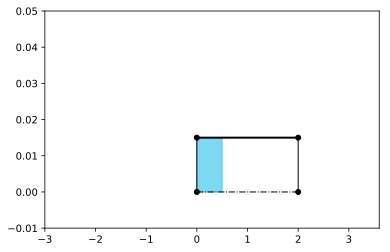

[output:0]

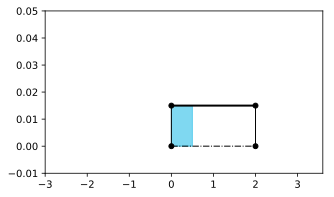

[output:1]

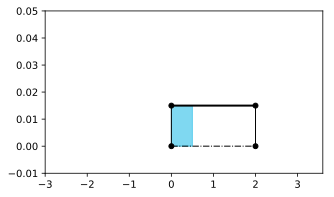

[output:2]

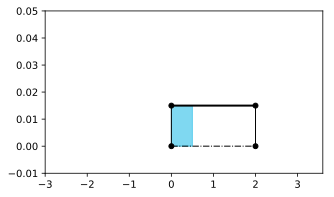

[output:3]

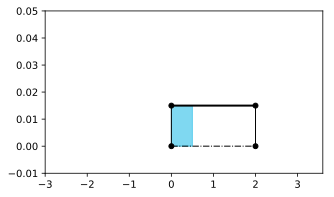

[output:4]

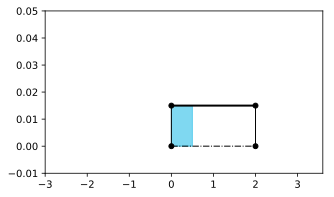

[output:5]

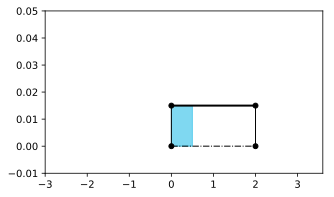

[output:6]

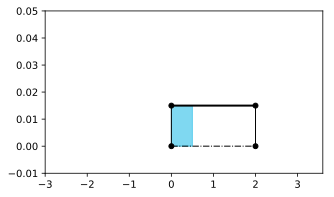

[output:7]

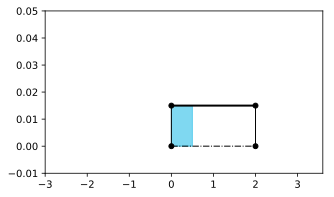

[output:8]

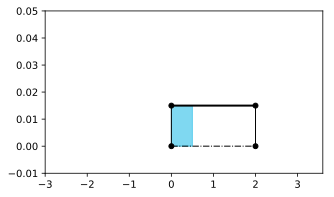

[output:9]

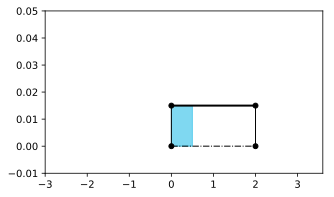

[output:10]

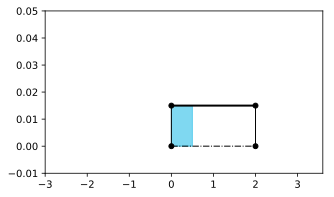

[output:11]

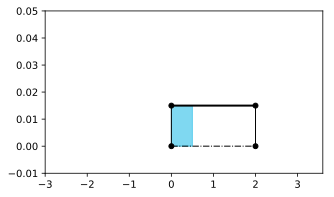

In [15]:
%%px --local
gas_layer_dict = {
        'type': 'gas',
        'name': 'He',
        'gamma': 1.66,
        'kappa': 0.005925,
        'R': 2078,
        'T_0': 300, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': 100e6, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': 0
    }
gas_layer_dict = {
        'type': 'gas',
        'name': 'Air',
        'gamma': 1.4,
        'kappa': 0.0,
        'R': 287,
        'T_0': 300, # K
        'p_0': 100e6, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': 0.5
    }
def get_simple_gl(**kwargs):
#     'type': 'gas',
    #     'name': 'He',
    #     'gamma': 1.66,
    #     'kappa': 0.005925,
    #     'R': 2078,

    #     'type': 'gas',
    #     'name': 'Air',
    #     'gamma': 1.4,
    #     'kappa': 0.0010838,
    #     'R': 287,
    
    gas_layer_dict_local = dict(gas_layer_dict)
    index_anchor = 100
    calc_settings = {
        'cell_dx': 0.0025,
        'n_cells': 600,
        'n_cells_min': 13,
        'n_cells_max': 200,
        'GasFluxCalculator_kwargs': {'flux_type':1, 'x_order':1},
        'GridStrecher_kwargs': {'strech_type': 1, 'index_anchor':index_anchor}
    } 
    if 'tube' in kwargs:
        tube = kwargs['tube']
    else:
        tube_dict = {
            'tube_points': [[-d*100,3*d],[-d*5,3*d],[-3*d,d],[0, d], [100*d, d]]
        }
        tube = Tube.get_standart(tube_dict)
    
    ro_0 = gas_layer_dict_local['p_0']/(gas_layer_dict_local['R']*gas_layer_dict_local['T_0'] + \
                                        gas_layer_dict_local['p_0']*gas_layer_dict_local['kappa'])
    omega = q_max * kwargs.get('omega_gas_multy', 5)
    gas_layer_dict_local['W_0'] = omega / ro_0
    x1 = tube.get_x1(gas_layer_dict_local['x_2'], gas_layer_dict_local['W_0'])
    x1=0
    gas_layer_dict_local['p_0'] = kwargs.get('p_0', 100e6)
    
    gl = GasLayer.get_standart(tube, x1, gas_layer_dict_local, calc_settings)   
#     xs_bord0 = np.linspace(x1, -10*d, 2*(index_anchor+1)//3)
#     xs_bord1 = np.linspace(-10*d, -2*d, (index_anchor+1)-len(xs_bord0)+1)[1:]
#     xs_bord2 = np.linspace(-2*d, gas_layer_dict_local['x_2'], gl.n_cells-index_anchor+1)[1:]
#     xs_bord = np.concatenate([xs_bord0, xs_bord1, xs_bord2])
    
#     gl.xs_borders[:] = xs_bord
    gl.init_SsdW()
    gl.init_q()
    gl.init_taus_acustic()
    return gl

gl = get_simple_gl(p_0=5e6, tube=tube, )
fig, ax = plt.subplots()
tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.01,0.05)
ax.set_xlim(-100*d,120*d)
plt.show()

# gl.xs_borders.shape, xs_board.shape, xs_bord[index_anchor]+2*d, xs_bord[-1]


In [13]:
tube.get_W_between(gl.xs_borders[0], 0) * 1000

7.396927649999885

In [16]:
lrs = [gl]
b = BorderSimple(gl, None, 0.1, 0)
vl = 0
for i in tqdm_notebook(range(15000)):
    if lrs[-1].xs_borders[-1] > tube.get_xs()[-1]:
        break
    tau = lrs[-1].get_tau_min()*0.5
    b.update_xs()
    b.update_Vs(tau)
    gl = gl.step_up(tau, False)
    lrs.append(gl)
    b.lr_left = gl
    
 

In [18]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=25, value=0))
def plotMe(ind):
    
    lr = lrs[ind]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    tube.plot(fig, ax2)
    ax2.set_ylim(-0.005, 0.09)
    lr.plot(fig, ax2)
    
    param_name = 'us'

    xs = np.array(lr.xs_borders)
    ys = np.array(lr.Vs_borders)
    color = lr.color_4_plot
    lw = 2
    ax0.plot(xs, ys, color=color, label=f'Vs', lw=0, marker='o', ms=0.2)
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    ax0.plot(xs, ys, color=color, lw=lw, label=f'{param_name} газ')

    ax0.grid(True)
    ax0.set_ylabel(param_name)
#     ax0.set_ylim(900,1000)
    ax0.set_title(f't={lr.time*1000} ms; i={ind}')
    ax0.legend()
    
    param_name = 'ps'
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax1.plot(xs, ys, color=color, lw=lw, label=f'{param_name} газ')
#     ax1.plot(xs, lr.get_Ts(gas_layer_dict['R'])-273, color=color, lw=lw, label=f'{param_name} газ')
    
    ax1.grid(True)
    ax1.set_ylabel(f'${param_name}$, ')
#     ax1.set_ylim(-500,700)
#     ax1.set_title(f't={lr.time*1000} ms; i={ind}')
    ax1.set_xlim(0, 2)
    ax1.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=5255, step=25), Output()), _dom_classes=('widg…

In [19]:
gl.time

0.011997735314726607

In [24]:
res4kurs = {
    'ts': np.array([lr.time for lr in lrs]),
    'Vs': np.array([lr.Vs_borders[-1] for lr in lrs]),
    'p_porsh': np.array([lr.ps[-1] for lr in lrs]),
    'p_dno': np.array([lr.ps[0] for lr in lrs]),
}

for k, arr in res4kurs.items():
    with open(r'C:\Users\Михаил\Google Диск\00_teaching 2019\газовая динамика курсач\пример\\'+k, 'wb') as f:
        np.save(f, arr)

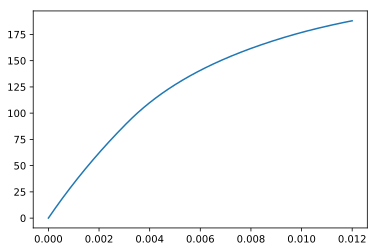

In [21]:
plt.plot(res4kurs['ts'], res4kurs['Vs'])
plt.show()

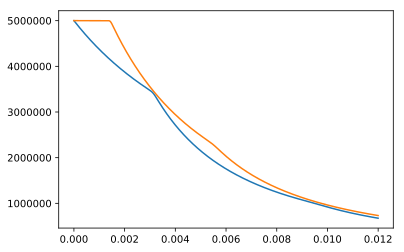

In [22]:
plt.plot(res4kurs['ts'], res4kurs['p_porsh'])
plt.plot(res4kurs['ts'], res4kurs['p_dno'])
plt.show()

In [14]:
# xs = [lr.time for lr in lrs]
# epot = np.array([lr.get_E_potential() for lr in lrs])
# ekinet =np.array([lr.get_E_kinetic()  for lr in lrs])
# esum =np.array([(lr.get_E_sum() + b.mass*lr.Vs_borders[-1]**2/2-lrs[0].get_E_sum())/lrs[0].get_E_sum()*100  for lr in lrs])    
# # plt.plot(xs, epot, label='epot')
# # plt.plot(xs, ekinet, label='ekinet')
# plt.plot(xs, esum, label='e error, %')
# plt.legend()
# plt.grid()
# plt.show()

In [15]:
# def get_v_d(Cq):
#     gl = get_simple_gl()
#     d = 23e-3
#     q = Cq * (d*10)**3
#     b = BorderSimple(gl, None, q, 0)
#     vl = 0
#     for i in range(100000):
#         if gl.xs_borders[-1] > tube.get_xs()[-1]:
#             break
#         tau = gl.get_tau_min()*0.4
#         b.update_xs()
#         b.update_Vs(tau)
#         gl = gl.step_up(tau, False)
#         b.lr_left = gl
#     return gl.Vs_borders[-1]

In [16]:
np.linspace(0.1, 20, 200)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. ,
       11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1,
       12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2,
       13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3,
       14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15

In [17]:
# Cqs = np.linspace(0.1, 20, 200)
# vds = [get_v_d(Cq) for Cq in tqdm_notebook(Cqs)]

In [18]:
# plt.plot(Cqs, vds)
# plt.grid()
# plt.show()

In [19]:
# cqs_vds = np.array([Cqs, vds])
# np.save('He_simple_p100', cqs_vds)

In [20]:
pi

3.141592653589793

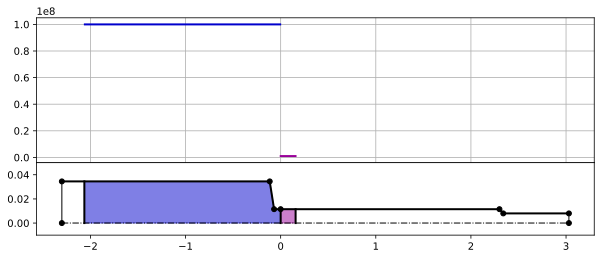

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

[output:0]

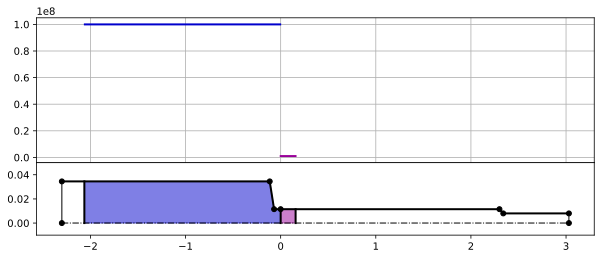

[output:1]

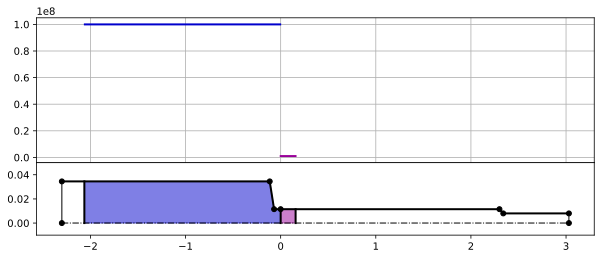

[output:2]

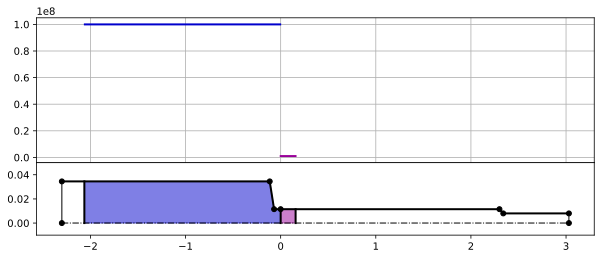

[output:3]

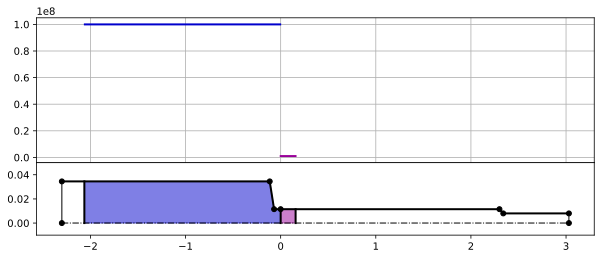

[output:4]

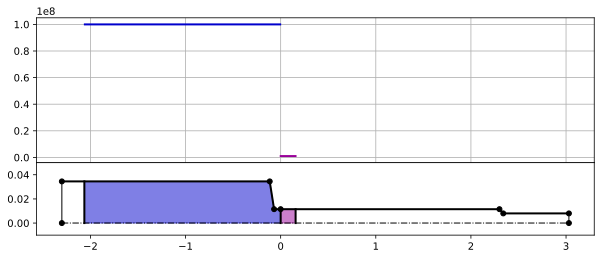

[output:5]

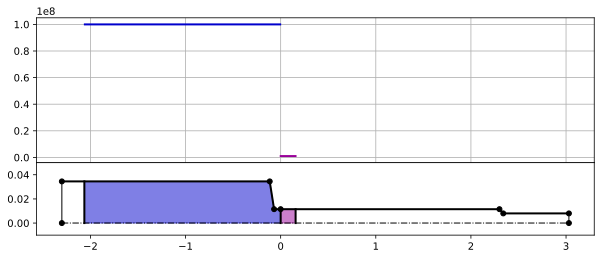

[output:6]

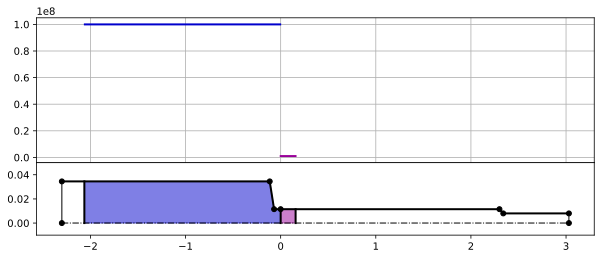

[output:7]

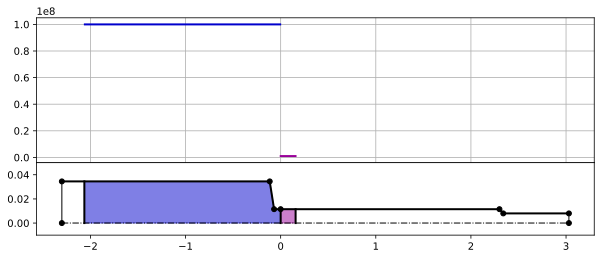

[output:8]

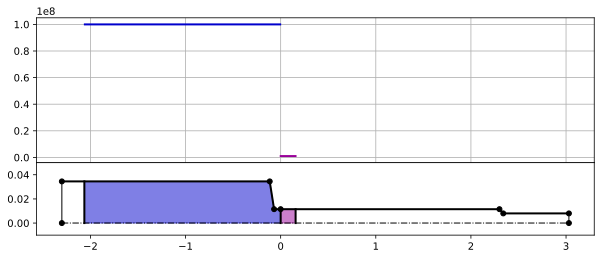

[output:9]

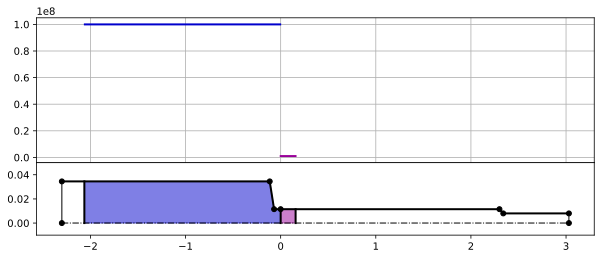

Out[0:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[1:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[2:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[3:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[4:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[5:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[6:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[7:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[8:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

Out[9:9]: 
Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':1000000.0, 'tau_min': 6.807189995204289e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0015713611395221788, 
        'x_1': 0.0, 'x_2': 0.1571361139522196,
        'V_1':  0.0, 'V_2':  0.0  }

In [22]:
%%px --local

class Sandwich(object):
    @classmethod
    def get_sandw(cls, **kwargs):
#         tube_dict = {
#             'tube_points': [[-d*100,3*d],[-d*5,3*d],[-3*d,d],[0, d], [100*d, d]]
#         }
        alpha = kwargs.get('alpha', 15)*pi/180
        d2 = kwargs.get('d2', 10)/1000
        d = tube_dict['tube_points'][-1][1]
        l_cone = (d - d2)/2/tan(alpha)
        x2 = tube_dict['tube_points'][-1][0] + l_cone
        tube2_dict = {
            'tube_points': tube_dict['tube_points'] + [[x2, d2], [x2+30*d, d2]] 
        }
        tube = Tube.get_standart(tube2_dict)
        res = cls(tube)
        
        gl = get_simple_gl(tube=tube, p_0=kwargs.get('p_0', 100e6))
        res.layers.append(gl)
        q_pereg = kwargs.get('q_pereg', 100)/1000
        b99 = BorderSimple(None, None, 10000, 1e14)
        res.borders.append(b99)
        b1 = BorderSimple(None, None, q_pereg, 0)
        res.borders.append(b1)
        
        pist_omega = kwargs.get('pist_omega', 30)/1000
        pist_layer_dict = {
            'type': 'pist',
            'omega': pist_omega,  # кг
            'p_0': 1e6, # начальное давление в полиэтилене
            'u_0': 0,     #начальная скорость
            'ElPistEOS_kwargs': dict(
                k=1.63098, 
                c_0=2308, 
                ro_0=919.03, 
                sigma_star=25.2, 
                k_0=0.054, 
                b_1=0.027, 
                b_2=0.00675, 
                tau_0=1.36, 
                mu=0.001, 
                tau_s=1,                 
                zeroP=False, 
                zeroE=True)
        }
        calc_settings_pist = {
            'cell_dx': 0.0005,
        #     'n_cells': 600,
            'n_cells_min': 13,
            'n_cells_max': 100,
            'GasFluxCalculator_kwargs': {'flux_type':1},
            'GridStrecher_kwargs': {}
        }
        pist_lr = ElPistLayer.get_standart(tube, 0, pist_layer_dict, calc_settings_pist) 
        res.layers.append(pist_lr)
        
        Cq = kwargs.get('Cq', 1)
        q = Cq * (d*10)**3
        b = BorderSimple(None, None, q, 0)
        res.borders.append(b)
        res.connect_borders_layers()
        return res
        
                                     
    def __init__(self, tube: Tube, i=0):
        self.tube = tube
        self.i = i
        self.layers = []
        self.borders= []
        
    def connect_borders_layers(self):
        if len(self.layers)+1 != len(self.borders):
            raise AttributeError(f'Неправильное количество границ и слоев len(self.layers)={len(self.layers)}  len(self.borders)={len(self.borders)}')
        all_layers = [None] + self.layers + [None]
        for b, lr_left, lr_right in zip(self.borders, all_layers[:-1], all_layers[1:]):
            b.lr_left = lr_left
            b.lr_right = lr_right
        
    def simple_step(self, courant):
        tau = min([lr.get_tau_min() for lr in self.layers]) * courant
        for b in self.borders:
            b.update_xs()
        for b in self.borders:
            b.update_Vs(tau)
        result = Sandwich(self.tube, self.i+1)
        result.layers = [lr.step_up(tau) for lr in self.layers]
        result.borders= [b.copy() for b in self.borders]
        result.connect_borders_layers()
        return result
    
    def plot(self, fig, ax, **kwargs):
        self.tube.plot(fig, ax, **kwargs)
        for lr in self.layers:
            lr.plot(fig, ax, **kwargs)
        for b in self.borders:
            b.plot(fig, ax, **kwargs)
            
    def plot_param(self, fig, ax, param_name, **kwargs):
        for lr in self.layers:
            xs = np.array(lr.xs_cells)
            ys = np.array(getattr(lr, param_name))
            color = lr.color_4_plot
            lw = kwargs.get('lw', 2)
            ax.plot(xs, ys, color=color, lw=lw)
            
    def get_t(self):
        ts = [lr.time for lr in self.layers]
        if abs(min(ts) - max(ts)) > 1e-14:
            print(f'Слои не синхронизированны {ts}')
        return ts[0]
    
    def get_vel(self):
        return self.layers[-1].Vs_borders[-1]
    
    def get_x_projectile(self):
        return self.layers[-1].xs_borders[-1]

    
    def get_p_max(self):
        return max([np.max(lr.ps) for lr in self.layers])
    
    def __str__(self):
        res = f'Sandwich i={self.i}; t={self.get_t()*1000} ms;  vel={self.get_vel()} m/s;  p_max={self.get_p_max()*1e-6} MPa\nlayers:\n'
        for i, lr in enumerate(self.layers):
            res += f'{i}) {lr}\n'
        return res
    
    def __repr__(self):
        return str(self)
        
sandw = Sandwich.get_sandw(alpha=5, p_0=100e6, q_pereg=10, pist_omega=60, d2=16, Cq=2)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'ps')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.01,0.05)
# ax2.set_xlim(100*d-0.1,100*d+0.1)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw

In [23]:
history = [sandw]
v = -10
for i in tqdm_notebook(range(150000)):
    if sandw.get_x_projectile() > sandw.tube.get_x_right():
        break
    if sandw.get_x_projectile() > 100*d and sandw.layers[-1].Vs_borders[-1] < v:
        break
    v = sandw.layers[-1].Vs_borders[-1]
    sandw = sandw.simple_step(0.35)
    if i>0 and i % 10 == 0:
        history.append(sandw)
    else:
        history[-1] = sandw


In [24]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(history)-1,step=1, value=len(history)-1))
def plotMe(ind):
    sandw = history[ind]

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    sandw.plot_param(fig, ax1, 'ps')
    sandw.plot(fig, ax2)
    sandw.plot_param(fig, ax0, 'us')
    ax2.set_ylim(-0.01,0.04)
#     ax0.set_xlim(2,2.5)
    ax1.grid(True)
    ax0.grid(True)
    plt.subplots_adjust(hspace=.0)

    plt.show()
    print(sandw)

interactive(children=(IntSlider(value=2511, description='ind', max=2511), Output()), _dom_classes=('widget-int…

In [25]:
%%px --local
from scipy.optimize import minimize
import csv
from pathlib import Path

In [26]:
mywd = os.getcwd()
mywd

'D:\\pyKas\\jupyters\\алучшелибикас'

In [27]:
cl[:]['mywd'] = mywd

In [28]:
%%px --local
diaps = [(3, 15), (5,21), (1,20), (5, 40)]
def objective(x, Cq, verbose=False):
    try:
#         g1 = DRange(100e6, 100e6, 'p_0')
#         g2 = DRange(3, 15, 'alpha')
#         g3 = DRange(5, 21, 'd2')
#         g4 = DRange(1, 20, 'q_pereg')
#         g5 = DRange(5, 40, 'pist_omega')
        
        kw = dict(
            p_0 =   100e6,
            alpha = diaps[0][0] + x[0]*(diaps[0][1] - diaps[0][0]),
            d2 =    diaps[1][0] + x[1]*(diaps[1][1] - diaps[1][0]),
            q_pereg = diaps[2][0] + x[2]*(diaps[2][1] - diaps[2][0]),
            pist_omega = diaps[3][0] + x[3]*(diaps[3][1] - diaps[3][0]),
            Cq=Cq)
        sandw = Sandwich.get_sandw(**kw)
        if verbose:
            print(f'{kw} in progress....')
        v = -10
        p_max = 10
        n = 250000
        it = tqdm_notebook(range(n)) if verbose else range(n)
        for i in it:
            if sandw.get_x_projectile() > sandw.tube.get_x_right():
                break
            if sandw.get_x_projectile() > 100*d and sandw.layers[-1].Vs_borders[-1] < v:
                break
            v = sandw.layers[-1].Vs_borders[-1]
            pm = sandw.get_p_max()
            if pm > p_max:
                p_max = pm
            if pm > 2500e6:
                break
            sandw = sandw.simple_step(0.4)
        else:
            raise Exception('s')
        
        def shtraffoo(p):
            p_shtraf = 2000e6
            if p < p_shtraf:
                return 0
            p_max1 = 2500e6
            v_shtraf = 1000
            k = v_shtraf / (p_max1 - p_shtraf)
            b = -k * p_shtraf
            return k * p + b
        
        shtraf = shtraffoo(p_max)
        fit = v - shtraf
        if verbose:
            print(f'{kw} done \nv={v:.3f} p={p_max/1e6:.0f} MПa, shtraf={shtraf:.2f} м/с, fit={fit:.3f}')
        fn = mywd+f'\\p_max_2GPa.csv'
        my_file = Path(fn)
        write_header = not my_file.is_file()
        with open(fn, 'a', newline='') as f:
            kw['V_max'] = v
            kw['p_max'] = p_max
            kw['shtraf'] = shtraf
            kw['fit'] = fit
            writer = csv.DictWriter(f, fieldnames=list(kw))
            if write_header:
                writer.writeheader()
            writer.writerow(kw)
        return -fit
    except Exception as e:
        kw['fit'] = -999
        return 999
    
bnds = ((0, 1), (0,1), (0,1), (0, 1))
cons=[]

In [29]:
%%px --local
def get_curr_best(Cq):
    fn = mywd+f'\\Cq_{Cq}.csv'
    data = []
    with open(fn) as f:
        reader = csv.DictReader(f)
        for d in reader:
            d = {k: float(d[k]) for k in d}
            data.append(d)
    best_dict = seq(data).max_by(lambda od: float(od['fit']))
    result = np.zeros(4)
    result[0] = (best_dict['alpha'] - diaps[0][0])/(diaps[0][1] - diaps[0][0])
    result[1] = (best_dict['d2']    - diaps[1][0])/(diaps[1][1] - diaps[1][0])
    result[2] = (best_dict['q_pereg'] - diaps[2][0])/(diaps[2][1] - diaps[2][0])
    result[3] = (best_dict['pist_omega'] - diaps[3][0])/(diaps[3][1] - diaps[3][0])
    return result

def get_curr_best2000(Cq):
    fn = mywd+f'\\p_max_2GPa.csv'
    data = []
    with open(fn) as f:
        reader = csv.DictReader(f)
        for d in reader:
            d = {k: float(d[k]) for k in d}
            data.append(d)
    top_gener = [d for d in data if abs(d['Cq'] -Cq)<0.001]
    best_dict = seq(top_gener).max_by(lambda od: float(od['fit']))
    result = np.zeros(4)
    result[0] = (best_dict['alpha'] - diaps[0][0])/(diaps[0][1] - diaps[0][0])
    result[1] = (best_dict['d2']    - diaps[1][0])/(diaps[1][1] - diaps[1][0])
    result[2] = (best_dict['q_pereg'] - diaps[2][0])/(diaps[2][1] - diaps[2][0])
    result[3] = (best_dict['pist_omega'] - diaps[3][0])/(diaps[3][1] - diaps[3][0])
    return result   

    
get_curr_best2000(0.1)

array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[0:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[1:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[2:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[3:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[4:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[5:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[6:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[7:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[8:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

Out[9:12]: array([0.21786242, 0.4612187 , 0.29997886, 0.15934429])

In [30]:
objective(get_curr_best2000(0.1), 0.1, True)

{'p_0': 100000000.0, 'alpha': 5.614349079507351, 'd2': 12.379499181879263, 'q_pereg': 6.6995983442875895, 'pist_omega': 10.577049990730785, 'Cq': 0.1} in progress....


{'p_0': 100000000.0, 'alpha': 5.614349079507351, 'd2': 12.379499181879263, 'q_pereg': 6.6995983442875895, 'pist_omega': 10.577049990730785, 'Cq': 0.1} done 
v=2960.272 p=2000 MПa, shtraf=0.00 м/с, fit=2960.272



-2960.271524562991

In [31]:
%%px --local
def mapfoo(c_q):
    x0 = get_curr_best2000(c_q)
    sol = minimize(objective,x0, args=(c_q,False), method='SLSQP', bounds=bnds)
    return str(sol)

In [32]:
cqs = np.array([0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
ress = lbv.map(mapfoo, cqs)

In [ ]:
# ress.add_done_callback(lambda x: print(x))

In [35]:
for r in ress:
    print(r)

     fun: -2960.2731890612076
     jac: array([ -511.45230103,  2312.38684082,   280.78521729, -1530.34088135])
 message: 'Optimization terminated successfully.'
    nfev: 14
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.2178629 , 0.46121842, 0.29997868, 0.1593448 ])
     fun: -2626.5975327842734
     jac: array([  12027.24014282,  -10416.95263672,  -70740.3706665 ,
       1099489.26434326])
 message: 'Positive directional derivative for linesearch'
    nfev: 6
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([0.23907173, 0.40265866, 0.50792546, 0.05849662])
     fun: -2335.439619156447
     jac: array([ 22231.28436279,  -4384.16003418,  34621.63632202, -62945.71716309])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.1708419 , 0.42307266, 0.3460514 , 0.1884511 ])
     fun: -2033.0384603264736
     jac: array([-989.61398315,  496.46685791,  -11.45079041, -765.

In [33]:
import glob

In [34]:
all_data = []
for fn in glob.glob('*.csv'):
    with open(fn) as f:
        reader = csv.DictReader(f)
        for l in reader:
            all_data.append(l)

In [35]:
grouped = seq(all_data).group_by(lambda d: d['Cq']).to_list()
cqs = seq(grouped).map(lambda tp: (tp[0], seq(tp[1])\
    .max_by(lambda od: float(od['fit']))['V_max']))\
    .map(lambda tp: (float(tp[0]), float(tp[1]))).sorted(lambda tp: tp[0]).to_list()
cqs = np.array(cqs).T
# cqs

In [36]:
cqs_vds = np.load('He_simple_p100.npy')
# cqs_vds

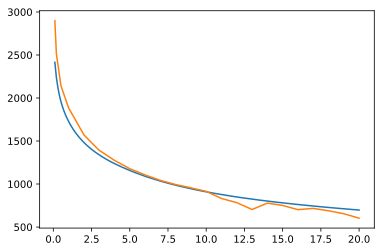

In [37]:
plt.plot(cqs_vds[0], cqs_vds[1])
plt.plot(cqs[0], cqs[1])
plt.show()

In [38]:
grouped = seq(all_data).group_by(lambda d: d['Cq']).to_list()
cqss = seq(grouped).map(lambda tp: (tp[0], seq(tp[1]).max_by(lambda od: float(od['fit']))))\
    .sorted(lambda tp: tp[0]).to_list()

### Другой подход (genetic)

In [36]:
%load_ext autoreload
%autoreload 

In [37]:

from opti.Chromosome import DRange, ChromoController
%autoreload 0

In [38]:
g1 = DRange(100e6, 100e6, 'p_0')
g2 = DRange(3, 15, 'alpha')
g2.mutate_part = 0.3
g3 = DRange(5, 21, 'd2')
g3.mutate_part = 0.3
g4 = DRange(1, 20, 'q_pereg')
g4.mutate_part = 0.3
g5 = DRange(5, 40, 'pist_omega')
g5.mutate_part = 0.3
chromo_contr = ChromoController([g1, g2, g3, g4, g5])

In [39]:
chromo_contr.get_chromo()

{'p_0': 100000000.0,
 'alpha': 8.436977910315072,
 'd2': 19.679585325715617,
 'q_pereg': 15.486025036136391,
 'pist_omega': 5.252336723617662}

In [40]:
%%px --local
from sqlitedict import SqliteDict

def fitness_foo(chromo, Cq, verbose=False):
    try:
        diaps = [(10e6, 100e6), (3, 30), (5,20), (1,50), (20, 150)]
        kw = dict(chromo)
        kw['Cq'] = Cq
        kw['V_max'] = -1
        kw['p_max'] = -1
        kw['shtraf'] = 999
        kw['fit'] = -999
        sandw = Sandwich.get_sandw(**kw)
        if verbose:
            print(f'{kw} in progress....')
        v = -10
        p_max = 10
        n = 250000
        it = tqdm_notebook(range(n)) if verbose else range(n)
        for i in it:
            if sandw.get_x_projectile() > sandw.tube.get_x_right():
                break
            if sandw.get_x_projectile() > 100*d and sandw.layers[-1].Vs_borders[-1] < v:
                break
            v = sandw.layers[-1].Vs_borders[-1]
            pm = sandw.get_p_max()
            if pm > p_max:
                p_max = pm
            if pm > 2500e6:
                break
            sandw = sandw.simple_step(0.4)
        else:
            raise Exception('s')
        
        def shtraffoo(p):
            p_shtraf = 2000e6
            if p < p_shtraf:
                return 0
            p_max1 = 2500e6
            v_shtraf = 1000
            k = v_shtraf / (p_max1 - p_shtraf)
            b = -k * p_shtraf
            return k * p + b
        
        shtraf = shtraffoo(p_max)
        fit = v - shtraf
        if verbose:
            print(f'{kw} done \nv={v:.3f} p={p_max/1e6:.0f} MПa, shtraf={shtraf:.2f} м/с, fit={fit:.3f}')
        fn = mywd+f'\\p_max_2GPa.csv'
        my_file = Path(fn)
        write_header = not my_file.is_file()
        with open(fn, 'a', newline='') as f:
            kw['V_max'] = v
            kw['p_max'] = p_max
            kw['shtraf'] = shtraf
            kw['fit'] = fit
            writer = csv.DictWriter(f, fieldnames=list(kw))
            if write_header:
                writer.writeheader()
            writer.writerow(kw)
        return kw
    except Exception as e:
        kw['fit'] = -999
        return kw

In [41]:
generation0 = [chromo_contr.get_chromo() for i in range(55)]
pop = [generation0]

In [42]:
# def to_chrome(od):
#     return {k: float(od[k]) for k in od}

# top_gener = [d for d in all_data if d['Cq'] == '3.0']
# generation0 = seq(top_gener)\
#     .sorted(lambda d: float(d['fit']), reverse=True) \
#     .take(20) \
#     .map(to_chrome) \
#     .to_list() \
#     + [chromo_contr.get_chromo() for i in range(23)]
# pop = [generation0]

In [43]:
# %%px --local
# def fitness_dummy(chromo, Cq, www):
#     chromo['fit'] = np.random.uniform(-10,10)
#     return chromo

In [48]:
import glob

def calc_gener(gener):
    res = [c for c in gener if 'fit' in c]
    need2calc = [c for c in gener if 'fit' not in c]
    res = lbv.map_sync(fit_foo, need2calc, ordered=False)
#     for r in ar:
#         res.append(r)
    return res

def get_elita(gener, n_elite):
    return seq(gener).sorted(lambda d: d['fit'], reverse=True).take(n_elite).to_list()

def get_children(gener, n_children):
    res = []
    for i in range(n_children):
        p1,p2,p3,p4 = np.random.choice(gener, size=4, replace=False)
        p1 = p1 if p1['fit'] > p2['fit'] else p2
        p2 = p3 if p3['fit'] > p4['fit'] else p4
        res.append(chromo_contr.cross(p1, p2))
    return res

def get_mutants(gener, n_mutants, p_mut_gene):
    res = []
    for i in range(n_mutants):
        p1 = np.random.choice(gener)
        res.append(chromo_contr.mutate_with_prob(p1, p_mut_gene))
    return res

n_children = 33
n_mut = 9
p_mut_gene = 0.1
n_elite = 4
for cqzz in [ 2.0]:
    cl[:]['cqzz'] = cqzz
    def fit_foo(chromo):
        return fitness_foo(chromo, cqzz, False)
    
    if abs(cqzz - 2.0) <1e-3:
        def to_chrome(od):
            return {k: float(od[k]) for k in od}
        all_data = []
        for fn in glob.glob('p_max_2GPa.csv'):
            with open(fn) as f:
                reader = csv.DictReader(f)
                for l in reader:
                    all_data.append(l)
        top_gener = [d for d in all_data if d['Cq'] == '2.0']
        generation0 = seq(top_gener)\
            .sorted(lambda d: float(d['fit']), reverse=True) \
            .take(7) \
            .map(to_chrome) \
            .to_list() \
            + [chromo_contr.get_chromo() for i in range(55)]
        pop = [generation0]
        n=10
    else:
        generation0 = [chromo_contr.get_chromo() for i in range(55)]
        pop = [generation0]
        n = 13

    pop[-1] = calc_gener(pop[-1])
    print(cqzz, end=' ')
    for i in range(n): 
        print(i, end=' ')
        elita = get_elita(pop[-1], n_elite)
        children = get_children(pop[-1], n_children)
        mutants = get_mutants(pop[-1], n_mut, p_mut_gene)
        pop.append(elita+children+mutants)
        pop[-1] = calc_gener(pop[-1])
    

2.0 0 1 2 3 4 5 6 7 8 9 

In [34]:
# sorted([d['fit'] for d in pop[-1]])

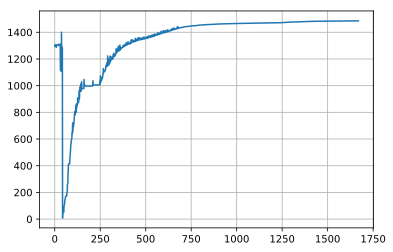

In [35]:
all_data = []
for fn in glob.glob('*.csv'):
    with open(fn) as f:
        reader = csv.DictReader(f)
        for l in reader:
            all_data.append(l)
top_gener = [d for d in all_data if d['Cq'] == '2.0']
all_vs = seq(top_gener)\
    .sorted(lambda d: float(d['fit'])) \
    .map(lambda d: float(d['V_max'])) \
    .to_list() 
plt.plot(all_vs)
plt.grid()
plt.show()

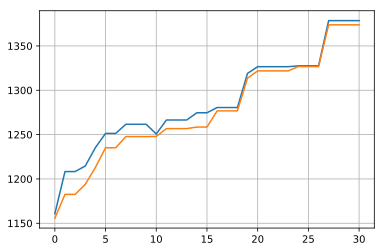

In [37]:
# bests = seq(pop).map(lambda g: seq(g).filter(lambda d: 'fit' in d).max_by(lambda c: c['fit'])['V_max']).to_list()
# bests2 = seq(pop).map(lambda g: seq(g).filter(lambda d: 'fit' in d).max_by(lambda c: c['fit'])['fit']).to_list()
# plt.plot(bests)
# plt.plot(bests2)
# plt.grid()
# plt.show()